# RailSectionProperties.json

In [ ]:
{
    "@RailSectionProperties": "I, Zhead, Zbase, c",
    "85": [30.07, 11.08, 12.17, 2.47],
    "115": [65.90, 18.00, 21.90, 2.99],
    "119": [71.40, 19.40, 22.80, 3.13],
    "132": [87.90, 22.40, 27.40, 3.20],
    "133": [86.20, 22.30, 26.90, 3.20],
    "136": [94.20, 23.70, 28.20, 3.34],
    "140": [95.90, 24.30, 28.60, 3.36],
    "141": [100.44, 25.24, 28.97, 3.40]
}

# Train.json

In [ ]:
{
    "Locomotive 1": {
        "static_load_values": [36250, 36250, 41375, 36410],
        "diameter_values": [36.00, 36.00, 36.00, 36.00],
        "distance_values": [83.75, 454.50, 83.75],
        "wheel_num": 4,
        "coupler_lengths": [40.25, 105.75]
    },
    "Locomotive 2": {
        "static_load_values": [40000, 46250, 56250, 66250, 76000, 86000],
        "diameter_values": [46.00, 45.00, 44.00, 43.00, 42.00, 41.00],
        "distance_values": [83.75, 80.00, 454.50, 80.00, 83.75],
        "wheel_num": 6,
        "coupler_lengths": [50.25, 115.75]
    },
    "Wagon 1": {
        "static_load_values": [36250, 36250, 41375, 36410],
        "diameter_values": [36.00, 36.00, 36.00, 36.00],
        "distance_values": [70.00, 416.00, 70.00],
        "wheel_num": 4,
        "coupler_lengths": [40.25, 40.25]
    },
    "Wagon 2": {
        "static_load_values": [50000, 60000, 70000, 80000],
        "diameter_values": [26.00, 26.00, 26.00, 26.00],
        "distance_values": [70.00, 416.00, 70.00],
        "wheel_num":4,
        "coupler_lengths": [40.25, 40.25]
    }
}


# Train.py

In [ ]:
import json

class Train:
    def __init__(self, car_params):
        self.car_params = car_params
        self.train_sequence = []

    def add(self, car_name):
        self.train_sequence.append(self.car_params[car_name])

    def remove(self):
        if self.train_sequence:
            self.train_sequence.pop()

    def clear_all(self):
        self.train_sequence = []
    
    def couple(self, car1, car2):
        car1_data = car1
        car2_data = car2
        
        car1_last_half = car1_data["wheel_num"] // 2
        car2_first_half = car2_data["wheel_num"] // 2

        coupled_car = {
            "static_load_values": car1_data["static_load_values"][-car1_last_half:] + car2_data["static_load_values"][:car2_first_half],
            "diameter_values": car1_data["diameter_values"][-car1_last_half:] + car2_data["diameter_values"][:car2_first_half],
            "distance_values": car1_data["distance_values"][-(car1_last_half-1):] + [car1_data["coupler_lengths"][1] + car2_data["coupler_lengths"][0]] + car2_data["distance_values"][:(car2_first_half-1)],
            "wheel_num": car1_last_half + car2_first_half,
            "coupler_lengths": [car1_data["coupler_lengths"][0], car2_data["coupler_lengths"][1]]
        }

        return coupled_car

# Track.py

In [ ]:
# track.py
import csv
import json

class Track:
    def __init__(self):
        self.track_params = []

    def load_rail_section_properties(self):
        with open('Rail_Section_Properties.json', 'r') as file:
            self.rail_props = json.load(file)

    def load_track_parameters(self, filename):
        with open(filename, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                row = {**row, **self.get_rail_section_properties(row["rail_section"])}
                self.track_params.append(row)

    def get_rail_section_properties(self, rail_section):
        rail_properties = self.rail_props[rail_section]
        property_names = self.rail_props["@RailSectionProperties"].split(", ")
        return dict(zip(property_names, rail_properties))

    def clear_all(self): # New method to clear all data
        self.track_params = []


# Bending_moment.py

In [ ]:
# bending_moment.py
from train import Train
import numpy as np

# The BendingMomentCalculator class is used to calculate the maximum bending moments along a given route.
class BendingMomentCalculator:
    # The class is initialized with a Train object and a Track object.
    def __init__(self, train, track):
        self.train = train
        self.track = track

    def calculate_max_bending_moments_along_route(self, speed):
        track = self.track.track_params
        _, max_configuration = self.get_max_configuration(self.train, track, speed)

        max_bending_moments = []
        dynamic_loads = []
        wheel_params_list = []
        combined_values_list = []
        for foot_data in track:
        #for foot_data in track[1:]:
            dynamic_load, wheel_params, combined_values, bending_moment = self.calculate_bending_moment(max_configuration, foot_data, speed)
            
            max_bending_moments.append(bending_moment)
            dynamic_loads.append(dynamic_load)
            wheel_params_list.append(wheel_params)
            combined_values_list.append(combined_values)

        return dynamic_loads, wheel_params_list, combined_values_list, max_bending_moments

    # This function calculates the maximum bending moment and the corresponding configuration by the first foot data.
    def get_max_configuration(self, train, track, speed):
        train_sequence = train.train_sequence
        max_bending_moment = -1  
        max_configuration = None

        for i in range(len(train_sequence)):
            _, _, _, bending_moment = self.calculate_bending_moment(train_sequence[i], track[0], speed)

            if bending_moment > max_bending_moment:
                max_bending_moment = bending_moment
                max_configuration = train_sequence[i]

            if i != len(train_sequence) - 1:
                coupled_car = self.train.couple(train_sequence[i], train_sequence[i+1])
                _, _, _, bending_moment = self.calculate_bending_moment(train_sequence[i], track[0], speed)

                if bending_moment > max_bending_moment:
                    max_bending_moment = bending_moment
                    max_configuration = coupled_car

        return max_bending_moment, max_configuration

    # This function calculates the maximum bending moment for a given car, foot data, and speed.
    def calculate_bending_moment(self, car, foot_data, speed):
        x = self.create_x_array()
        theta = self.calculate_theta(car, speed)
        dynamic_load = self.calculate_dynamic_load(car, theta)
        wheel_params = self.calculate_wheel_params(car, dynamic_load, foot_data, x)
        combined_values = self.calculate_combined_values(wheel_params)
        max_bending_moment = self.calculate_max_bending_moment(combined_values)

        return dynamic_load, wheel_params, combined_values, max_bending_moment
    
#From now on we calculater all the needed parameters

    # This function extracts the parameters from the foot data.
    def get_parameters_from_foot_data(self, foot_data):
        parameters = {
            'track_modulus': float(foot_data['track_modulus']),
            'rail_section': float(foot_data['rail_section']),
            'elasticity': float(foot_data['elasticity']),
            'tie_spacing': float(foot_data['tie_spacing']),
            'tie_width': float(foot_data['tie_width']),
            'tie_thickness': float(foot_data['tie_thickness']),
            'tie_length': float(foot_data['tie_length']),
            'tie_plate_width': float(foot_data['tie_plate_width']),
            'tie_plate_length': float(foot_data['tie_plate_length']),
            'inertia_moment': foot_data['I'],
            'zhead': foot_data['Zhead'],
            'zbase': foot_data['Zbase'],
            'c': foot_data['c']
        }
        return parameters

    # This function calculates the wheel rotation speed.
    def calculate_theta(self, car, speed):
        wheel_num = int(float(car['wheel_num']))
        theta = []
        for i in range(wheel_num):
            if float(car['diameter_values'][i]):
                theta.append((33*speed) / (100*float(car['diameter_values'][i])))
        return theta

    # This function calculates the dynamic load on each wheel.
    def calculate_dynamic_load(self, car, theta):
        wheel_num = int(float(car['wheel_num']))
        dynamic_load = np.zeros(wheel_num)
        for i in range(wheel_num):
            if float(car['diameter_values'][i]):
                dynamic_load[i] = int(float(car['static_load_values'][i]) + theta[i]*float(car['static_load_values'][i])) 
        return dynamic_load

    # This function calculates the parameters for each wheel based on the dynamic load and foot data.
    def calculate_wheel_params(self, car, dynamic_load, foot_data, x):
        parameters = self.get_parameters_from_foot_data(foot_data)
        track_modulus = parameters['track_modulus']
        elasticity = parameters['elasticity']
        inertia_moment = parameters['inertia_moment']
        beta = (track_modulus / (4*elasticity*inertia_moment))**0.25

        wheel_num = int(float(car['wheel_num']))
        x_length = len(x)
        wheel_params = np.zeros((wheel_num, 3, x_length))

        cumulative_distance = 0
        for i in range(wheel_num):
            if i > 0:
                cumulative_distance += car['distance_values'][i - 1]
            distance = cumulative_distance
            cosine = np.cos(beta * np.abs(x - distance))
            sine = np.sin(beta * np.abs(x - distance))
            wheel_params[i, 0, :] = np.round(dynamic_load[i] * ((elasticity * inertia_moment) / (64 * track_modulus)) ** 0.25 * np.exp(-1 * beta * np.abs(x - distance)) * (cosine - sine))  # M
            wheel_params[i, 1, :] = np.round(dynamic_load[i] / (8 * elasticity * inertia_moment * beta ** 3) * np.exp(-1 * beta * np.abs(x - distance)) * (cosine + sine), 2)  # w
            wheel_params[i, 2, :] = np.round((-1 * track_modulus * dynamic_load[i]) / (8 * elasticity * inertia_moment * beta ** 3) * np.exp(-1 * beta * np.abs(x - distance)) * (cosine + sine))  # p

        return wheel_params

    # This function sums up the parameters for all wheels to get the combined values.
    def calculate_combined_values(self, wheel_params):
        x_length = wheel_params.shape[2]
        combined_values = np.zeros((3, x_length))
    
        for i in range(3):
            combined_values[i, :] = wheel_params[:, i, :].sum(axis=0)
        return combined_values

    # This function finds the maximum bending moment from the combined values.
    def calculate_max_bending_moment(self, combined_values):
        max_bending_moment = np.max([np.abs(np.min(combined_values[0, :])), np.max(combined_values[0, :])])
        return float(max_bending_moment)

    # This function creates an array for the x values.
    def create_x_array(self, x_start=-300, x_interval=0.5, x_length=3100):
        x = np.arange(x_start, x_start + x_interval * x_length, x_interval)
        return x

    # This function calculates the area of the tie plate.
    def tie_plate_area(self, tie_plate_width, tie_plate_length):
        # Calculate the area.
        tie_plate_area = tie_plate_length * tie_plate_width

        return tie_plate_area

    # def tie_plate_area(self, tie_plate_width, tie_plate_length):
    #     # If parameters of tie plate are not 0, calculate the area.
    #     if tie_plate_width and tie_plate_length:
    #         tie_plate_area = tie_plate_length * tie_plate_width
    #     else:
    #         tie_plate_area = 0

    #     return tie_plate_area

    # This function calculates the maximum dynamic deflection.
    def max_dynamic_deflection(self, combined_values):
        max_deflection = np.round(float(np.max(combined_values[1,:])), 3)

        return max_deflection

    # This function calculates the maximum dynamic pressure.
    def max_dynamic_pressure(self, combined_values):
        max_pressure = np.round(np.max([np.abs(np.min(combined_values[2,:])), np.max(combined_values[2,:])]))

        return max_pressure

    # This function calculates the maximum dynamic rail seat force.
    def max_dynamic_railseat_force(self, max_pressure, tie_spacing):
        max_seat_force = np.round(max_pressure * tie_spacing)

        return max_seat_force

    # This function calculates the required rail section modulus.
    def required_rail_seciton_modulus(self, inertia_moment, rail_c):
        req_section_modulus = np.round(inertia_moment / rail_c, 2)

        return req_section_modulus

    # This function calculates the rail section modulus from the max bending moment results.
    def calculated_rail_section_modulus(self, max_bending_moment, alb_bending_stress):
        cal_section_modulus = np.round(max_bending_moment / alb_bending_stress, 2)
        
        return cal_section_modulus

    # This function calculates the bending stress from the max bending moment results.
    def calculated_bending_stress(self, max_bending_moment, rail_c, inertia_moment):
        cal_bending_stress = np.round((max_bending_moment * rail_c) / inertia_moment)

        return cal_bending_stress

    # This function calculates the rail-tie bearing stress.
    def calculated_rail_tie_bearing_stress(self, max_seat_force, tie_plate_area):
        cal_tie_bearing_stress = np.round(max_seat_force / tie_plate_area, 2)

        return cal_tie_bearing_stress

    # This function calculates the nonlinear rail-tie bearing stress.
    def non_linear_rail_tie_bearing_stress(self, max_seat_force, tie_plate_area):
        nonlinear_tie_bearing_stress = np.round((1.5 * max_seat_force) / tie_plate_area, 2)

        return nonlinear_tie_bearing_stress

    # This function calculates required tie plate size
    def req_tie_plate_size(self, max_seat_force, alb_tie_bearing_stress):
        req_plate_size = np.round((1.5 * max_seat_force) / alb_tie_bearing_stress, 2)
        
        return req_plate_size

    # This function calculates tie-ballast bearing stress
    def calculated_tie_ballast_bearing_stress(self, max_seat_force, tie_length, tie_width):
        cal_ballast_bearing_stress = np.round((1.5 * max_seat_force) / ((tie_length/3) * tie_width), 2)

        return cal_ballast_bearing_stress

    def mimimum_calculated_ballast_thickness(self, cal_ballast_bearing_stress, alb_ballast_stress):
        min_ballast_thickness = np.round(((16.8 * cal_ballast_bearing_stress) / alb_ballast_stress) ** 0.8, 2)

        return min_ballast_thickness

    def actual_ballast_subgrade_stress(self, cal_ballast_bearing_stress, min_ballast_thickness):
        actual_ballast_stress = np.round((16.8 * cal_ballast_bearing_stress) / min_ballast_thickness ** 1.25, 2)

        return actual_ballast_stress

# Tkinter_edit.py

In [ ]:
# tkinter_edit.py
import matplotlib.pyplot as plt
import tkinter as tk
import pandas as pd
from tkinter import filedialog
from tkinter import ttk
from bending_moment import BendingMomentCalculator

class Application(tk.Frame):
    def __init__(self, master=None, train=None, track=None, calculator=None):
        super().__init__(master)
        self.master = master
        self.master.title("BOEF Calculator v1.0")  # set the window title here
        self.train = train
        self.track = track
        self.calculator = calculator
        self.speed = 0  # Add this line to initialize the speed
        #self.input_file_path = None  # Add this line to initialize the input file path
        self.grid()
        self.create_widgets()
    
    # Add buttons
    def create_widgets(self):
        self.load_button = tk.Button(self) 
        self.load_button["text"] = "Load Track CSV"
        self.load_button["command"] = self.load_track_parameters # Load the track CSV file
        self.load_button.grid(row=0, column=0)

        self.add_button = tk.Button(self, text="Add", command=self.add) # Add a new car
        self.add_button.grid(row=0, column=1)

        self.speed_set_button = tk.Button(self, text="Speed Set", command=self.speed_set) # Speed set
        self.speed_set_button.grid(row=0, column=2)

        self.calculate_button = tk.Button(self, text="Calculate", command=self.calculate) # Calculate max bending moment
        self.calculate_button.grid(row=0, column=3)

        self.remove_button = tk.Button(self, text="Remove", command=self.remove) # Remove the last car
        self.remove_button.grid(row=0, column=4)

        self.clear_button = tk.Button(self, text="Clear", command=self.clear) # Clear all the inputs
        self.clear_button.grid(row=0, column=5)

        self.car_select = ttk.Combobox(self, values=["Locomotive 1", "Locomotive 2", "Wagon 1", "Wagon 2"]) # Select next input of car
        self.car_select.grid(row=1, column=0)

        self.train_sequence = tk.Label(self, text="Train Sequence: ") # Showing current sequence
        self.train_sequence.grid(row=2, column=0)

        self.status_label = tk.Label(self, text="")
        self.status_label.grid(row=4, column=0, columnspan=6, sticky="w")

    def load_track_parameters(self):
        filename = filedialog.askopenfilename()
        if filename:
            self.track.load_track_parameters(filename)
            self.input_file_path = filename  # save the filename
            self.status_label['text'] = "Track parameters CSV file loaded successfully."
        else:
            self.status_label['text'] = "No file selected."

    def clear(self):
        self.train.clear_all()  
        self.track.clear_all()  
        self.speed = 0
        self.train_sequence['text'] = "Train Sequence: "
        self.status_label['text'] = "Inputs cleared."
    
    def add(self):
        car = self.car_select.get()
        self.train.add(car)
        self.train_sequence['text'] += car + ", "

    def remove(self):
        self.train.remove()
        train_sequence = self.train_sequence['text']
        last_comma = train_sequence.rfind(',')
        if last_comma != -1:  # Check if there's any comma in the string
            second_last_comma = train_sequence.rfind(',', 0, last_comma)
            if second_last_comma == -1:  # If there's only one car left
                self.train_sequence['text'] = "Train Sequence: "
            else:  # If there's more than one car
                self.train_sequence['text'] = train_sequence[:second_last_comma + 1] + " "

    # Set speed
    def speed_set(self):
        def submit():
            try:
                speed = float(speed_entry.get())
                self.speed = speed  # Store the speed for later use
                self.status_label['text'] = f"Speed set to {speed} mph."
                speed_window.destroy()
            except ValueError:
                self.status_label['text'] = "Invalid input for speed."

        speed_window = tk.Toplevel(self.master)
        speed_window.title("Set Speed")

        speed_label = tk.Label(speed_window, text="Enter speed:")
        speed_label.grid(row=0, column=0)

        speed_entry = tk.Entry(speed_window)
        speed_entry.grid(row=0, column=1)

        submit_button = tk.Button(speed_window, text="Submit", command=submit)
        submit_button.grid(row=1, column=0, columnspan=2)

    def calculate(self):
        bending_moment_calculator = BendingMomentCalculator(self.train, self.track)
        dynamic_loads, wheel_params_list, combined_values_list, max_bending_moments = bending_moment_calculator.calculate_max_bending_moments_along_route(self.speed)

        # Read the input csv file
        df_input = pd.read_csv(self.input_file_path)  # use the loaded file

        # Copy the parameters from the input csv file
        foot_data = df_input["foot"]
        tie_plate_width = df_input["tie_plate_width"]
        tie_plate_length = df_input["tie_plate_length"]
        tie_spacing = df_input["tie_spacing"]
        rail_section = df_input["rail_section"]
        alb_bending_stress = df_input["allowable_bending_stress"]
        longitude = df_input["longitude"]
        latitude = df_input["latitude"]

        # Calculate tie plate area
        if (tie_plate_width != 0).all() and (tie_plate_length != 0).all():
            tie_plate_area = bending_moment_calculator.tie_plate_area(tie_plate_width, tie_plate_length)
        else:
            # handle case where either tie_plate_width or tie_plate_length contain zeros
            tie_plate_area = 0

        # Get rail section parameters
        # inertia_moment = [float(track_data['I']) for track_data in self.track.track_params if track_data['rail_section'] == rail_section]
        # rail_c = [float(track_data['c']) for track_data in self.track.track_params if track_data['rail_section'] == rail_section]
        
        # create a mapping from rail section to 'I' value
        inertia_moment_mapping = {track_data['rail_section']: float(track_data['I']) for track_data in self.track.track_params}

        # map the 'rail_section' column to corresponding 'I' values
        inertia_moment = rail_section.map(inertia_moment_mapping)

        # do the same for 'c' value
        rail_c_mapping = {track_data['rail_section']: float(track_data['c']) for track_data in self.track.track_params}
        rail_c = rail_section.map(rail_c_mapping)


        # Calculate dynamic parameters for each foot
        max_deflection = [bending_moment_calculator.max_dynamic_deflection(combined_values) for combined_values in combined_values_list]
        max_pressure = [bending_moment_calculator.max_dynamic_pressure(combined_values) for combined_values in combined_values_list]
        max_seat_force = [bending_moment_calculator.max_dynamic_railseat_force(max_pressure_val, tie_spacing_val) for max_pressure_val, tie_spacing_val in zip(max_pressure, tie_spacing)]
        
        # Required rail section modulus
        #req_section_modulus = [bending_moment_calculator.required_rail_seciton_modulus(inertia_moment_val, rail_c_value) for inertia_moment_val, rail_c_value in zip(inertia_moment, rail_c)]
        cal_section_modulus = [bending_moment_calculator.calculated_rail_section_modulus(max_bending_moment, alb_bending_stress_value) for max_bending_moment, alb_bending_stress_value in zip(max_bending_moments, alb_bending_stress)]

        # Create a new DataFrame to store the output data
        df_output = pd.DataFrame({
            "foot": foot_data,
            "max_bending_moment": max_bending_moments,
            "max_deflection": max_deflection,
            "max_pressure": max_pressure,
            "max_seat_force": max_seat_force,
            #"required_section_modulus": req_section_modulus,
            "calculated_section_modulus": cal_section_modulus,
            "longitude": longitude,
            "latidude": latitude
        })

        self.display_plot(max_bending_moments)

        # Write the output DataFrame to a CSV file
        #df_output.to_csv("/Users/mulinw/Library/CloudStorage/OneDrive-UniversityofIllinois-Urbana/Courses/23spring/597/CSV_Version/Vitor_Version_Test/output1.csv", index=False)  # replace "output.csv" with your desired output file path
        # Open a dialog for the user to choose the output file path
        output_file_path = filedialog.asksaveasfilename(defaultextension=".csv", filetypes=[("CSV files", "*.csv")])

        # Check if a file path was chosen
        if output_file_path:
            # Write the output DataFrame to a CSV file
            df_output.to_csv(output_file_path, index=False)  # use the chosen output_file_path
            self.status_label['text'] = f"Output CSV saved successfully at {output_file_path}."
        else:
            self.status_label['text'] = "No output file selected."
        


    def display_plot(self, max_bending_moments):
        plt.figure(figsize=(6, 5), dpi=100)
        ax = plt.gca()

        red_threshold = 500000
        yellow_threshold = 400000

        # Add threshold lines
        ax.axhline(red_threshold, color='red', linestyle='--')
        ax.axhline(yellow_threshold, color='yellow', linestyle='--')

        # Split data into red, yellow, and green segments
        for i, max_bending_moment in enumerate(max_bending_moments):
            if max_bending_moment > red_threshold:
                color = 'red'
            elif max_bending_moment > yellow_threshold:
                color = 'yellow'
            else:
                color = 'green'

            if i < len(max_bending_moments) - 1:
                ax.plot([i, i + 1], [max_bending_moments[i], max_bending_moments[i + 1]], color=color)

        ax.set_xlabel('Foot')
        ax.set_ylabel('Max Bending Moment')
        ax.set_title('Max Bending Moment along Route')
        plt.show()

# Main.py

<class 'list'>
inertia_moment 0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
742   NaN
743   NaN
744   NaN
745   NaN
746   NaN
Name: rail_section, Length: 747, dtype: float64
inertia_moment_mapping {'115': 65.9}
rail_c 0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
742   NaN
743   NaN
744   NaN
745   NaN
746   NaN
Name: rail_section, Length: 747, dtype: float64
rail_c_mapping {'115': 2.99}


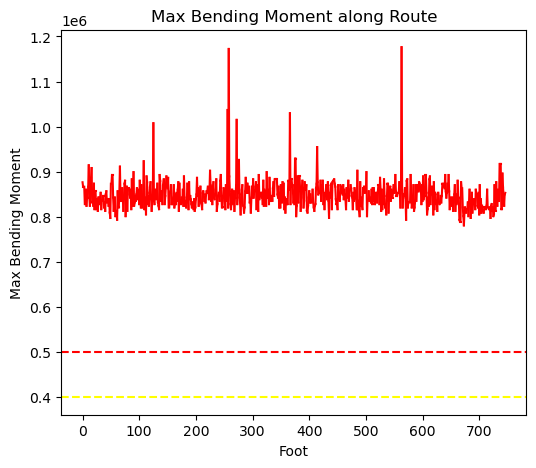

In [ ]:
# main.py
import json
from train import Train
from track import Track
from bending_moment import BendingMomentCalculator
from tkinter import Tk
from tkinter_edit import Application

# Load train data from Module.json
def load_car_parameters():
    with open('Train.json', 'r') as file:
        car_params = json.load(file)
    return car_params

def main():
    # Load train data
    car_params = load_car_parameters()
    
    # Create Train and Track objects
    train = Train(car_params)
    track = Track()  # track parameters will be loaded later via GUI
    track.load_rail_section_properties()

    # Create a BendingMomentCalculator object using the Train and Track objects
    bending_moment_calculator = BendingMomentCalculator(train, track)
    
    # Create and start the tkinter GUI
    root = Tk()
    app = Application(master=root, train=train, track=track, calculator=bending_moment_calculator)
    app.mainloop()

if __name__ == '__main__':
    main()
